<a href="https://colab.research.google.com/github/agrimsaharia/model-zoo-submissions/blob/main/Keras_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from keras.models import Model, load_model
from keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import keras.backend as K
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
ROWS = 32
COLS = 32
CHANNELS = 3
CLASSES = 10

Run the following code to normalize the dataset and learn about its shapes:

In [3]:
(xtrain, ytrain),(xtest,ytest) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 4s 0us/step


[6]


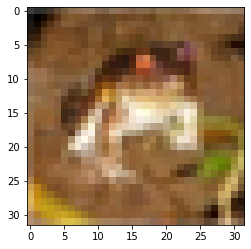

In [4]:
import matplotlib.pyplot as plt
plt.imshow(xtrain[0]/255)
print(ytrain[0])

In [5]:
xtrainsc = xtrain/255
xtestsc = xtest/255

ytraincat = tf.keras.utils.to_categorical(ytrain)
ytestcat = tf.keras.utils.to_categorical(ytest)

In [6]:
print ("number of training examples =", xtrainsc.shape[0])
print ("number of test examples =", xtestsc.shape[0])
print ("xtrainsc shape:", xtrainsc.shape)
print ("ytraincat shape:", ytraincat.shape)
print ("xtestsc shape:", xtestsc.shape)
print ("ytestcatat shape:", ytestcat.shape)

number of training examples = 50000
number of test examples = 10000
xtrainsc shape: (50000, 32, 32, 3)
ytraincat shape: (50000, 10)
xtestsc shape: (10000, 32, 32, 3)
ytestcatat shape: (10000, 10)


In [7]:
def identity_block(X, f, filters, stage, block):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value. We'll need this later to add back to the main path. 
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = 1, padding = 'valid', name = conv_name_base + '2a')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = f, strides = 1, padding = 'same', name = conv_name_base + '2b')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = 1, strides = 1, padding = 'valid', name = conv_name_base + '2c')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [8]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(filters=F1, kernel_size = 1, strides = s, name = conv_name_base + '2a')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=f, strides=(1, 1), padding='same', name=conv_name_base + '2b')(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=1, strides=(1, 1), padding='valid', name=conv_name_base + '2c')(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    
    ##### SHORTCUT PATH ####
    X_shortcut = Conv2D(filters=F3, kernel_size = 1, strides = s, padding='valid', name = conv_name_base + '1')(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [9]:
def ResNet50(input_shape = (64, 64, 3), classes = 2):   
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL.
    X = AveragePooling2D((2, 2), name='avg_pool', padding='same')(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

Run the following code to build the model's graph:

In [10]:
model = ResNet50(input_shape = (ROWS, COLS, CHANNELS), classes = CLASSES)

Now we need to configure the learning process by compiling the model.

In [11]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

The model is now ready to be trained. Run the following cell to train your model on 100 epochs with a batch size of 64:

In [12]:
model.fit(xtrainsc, ytraincat, epochs = 20, batch_size=64)

Epoch 1/20
782/782 [==============================] - 95s 49ms/step - loss: 2.2479 - accuracy: 0.3232
Epoch 2/20
782/782 [==============================] - 38s 49ms/step - loss: 1.9894 - accuracy: 0.3493
Epoch 3/20
782/782 [==============================] - 38s 49ms/step - loss: 1.8128 - accuracy: 0.3957
Epoch 4/20
782/782 [==============================] - 38s 49ms/step - loss: 1.8223 - accuracy: 0.4072
Epoch 5/20
782/782 [==============================] - 37s 48ms/step - loss: 1.6427 - accuracy: 0.4456
Epoch 6/20
782/782 [==============================] - 38s 48ms/step - loss: 1.8005 - accuracy: 0.4100
Epoch 7/20
782/782 [==============================] - 38s 48ms/step - loss: 1.5356 - accuracy: 0.4745
Epoch 8/20
782/782 [==============================] - 37s 48ms/step - loss: 1.4346 - accuracy: 0.5113
Epoch 9/20
782/782 [==============================] - 37s 48ms/step - loss: 1.5336 - accuracy: 0.5069
Epoch 10/20
782/782 [==============================] - 37s 48ms/step - loss: 1.375

Let's see how this model performs on the test set.

In [13]:
preds = model.evaluate(xtestsc, ytestcat)
preds

313/313 [==============================] - 8s 13ms/step - loss: 0.9623 - accuracy: 0.6597


[0.9623041152954102, 0.6596999764442444]

We can also print a summary of our model by running the following code:

In [14]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 16, 16, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________